# Grande Agriculture Dans La Tunisie

## Data Prep and Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Input
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [2]:
script_dir = script_dir = os.getcwd()

# Construct the absolute path to the PlantVillage directory
data_dir = os.path.join(script_dir, 'PlantVillage')
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy']


train_dir = os.path.join(data_dir)

In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,Pepper__bell___Bacterial_spot/0022d6b7-d47c-4e...,0,Pepper__bell___Bacterial_spot
1,Pepper__bell___Bacterial_spot/006adb74-934f-44...,0,Pepper__bell___Bacterial_spot
2,Pepper__bell___Bacterial_spot/00f2e69a-1e56-41...,0,Pepper__bell___Bacterial_spot
3,Pepper__bell___Bacterial_spot/01613cd0-d3cd-4e...,0,Pepper__bell___Bacterial_spot
4,Pepper__bell___Bacterial_spot/0169b9ac-07b9-4b...,0,Pepper__bell___Bacterial_spot


In [4]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Potato___Early_blight/d8a55ed1-7b3a-4b25-84b2-...,2,Potato___Early_blight
1,Pepper__bell___healthy/06ae69f3-53f7-4ad8-b6b0...,1,Pepper__bell___healthy
2,Pepper__bell___healthy/e7afc78e-d40c-4fd5-af4d...,1,Pepper__bell___healthy
3,Potato___Early_blight/dc2775b9-e62e-4fe5-921f-...,2,Potato___Early_blight
4,Pepper__bell___Bacterial_spot/0a0dbf1f-1131-49...,0,Pepper__bell___Bacterial_spot


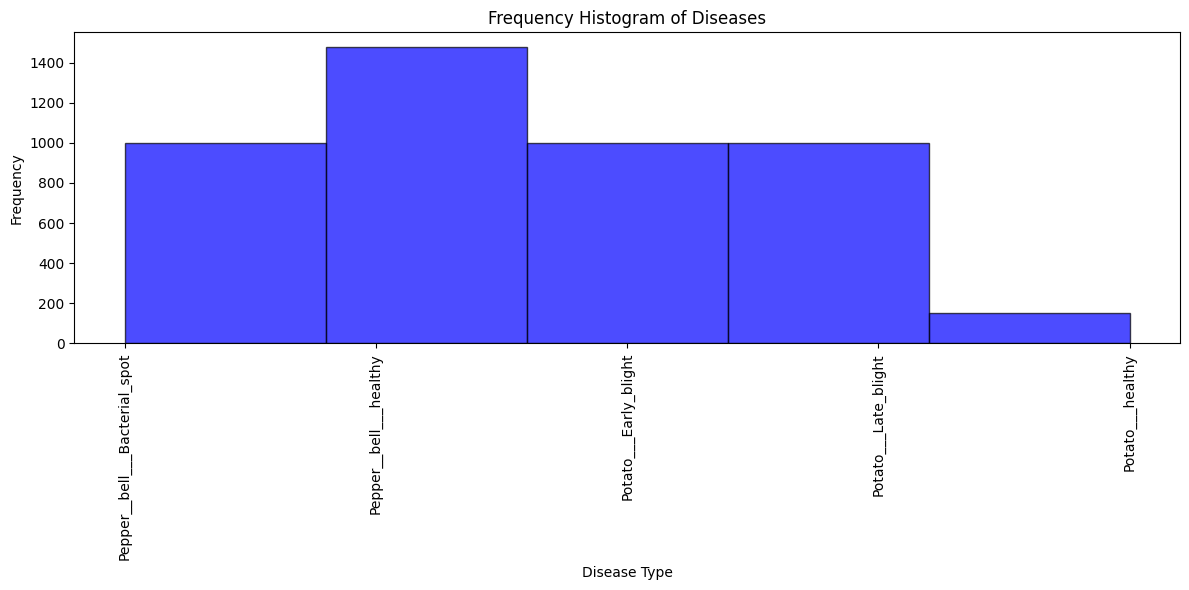

In [5]:
import matplotlib.pyplot as plt

# Adjusting the figure size before plotting the histogram
plt.figure(figsize=(12, 6))  # Adjusted to make the plot wider

# Plotting the histogram
plt.hist(train['DiseaseID'], bins=len(disease_types), alpha=0.7, color='blue', edgecolor='black')

# Setting the title
plt.title('Frequency Histogram of Diseases')

# Getting unique IDs and labels in the same order as they appear in the histogram
unique_ids = train['DiseaseID'].unique()
unique_ids.sort()
labels = [disease_types[i] for i in unique_ids]

# Setting custom x-ticks to show disease names instead of IDs
plt.xticks(ticks=unique_ids, labels=labels, rotation='vertical')

# Adding labels to the x and y axes
plt.xlabel('Disease Type')
plt.ylabel('Frequency')

# Displaying the plot
plt.tight_layout()  # Adjust layout to make room for the rotated x-tick labels
plt.show()


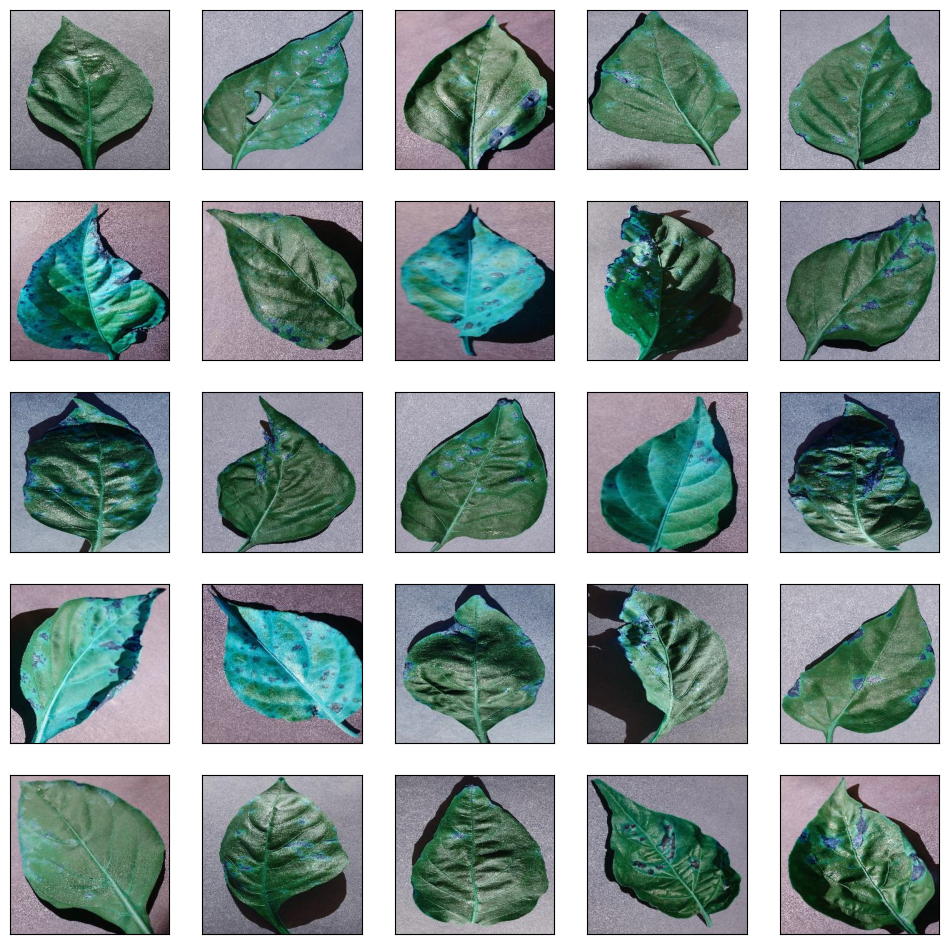

In [11]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    num_files = len(defect_files)
    if num_files == 0:
        print("No files found for defect type:", defect_types)
        return
    n = 0
    for i in range(rows):
        for j in range(cols):
            if n < num_files:
                image_path = os.path.join(data_dir, defect_files[n])
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
                ax[i, j].imshow(cv2.imread(image_path))
                n += 1
            else:
                break

# Displays first n images of class from training set
plot_defects('Pepper__bell___Bacterial_spot', 5, 5)


In [12]:
#normalize size of input images
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [13]:
#: Scaling pixel values to [0, 1]
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

4627it [00:26, 172.93it/s]


Train Shape: (4627, 64, 64, 3)


In [14]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [15]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

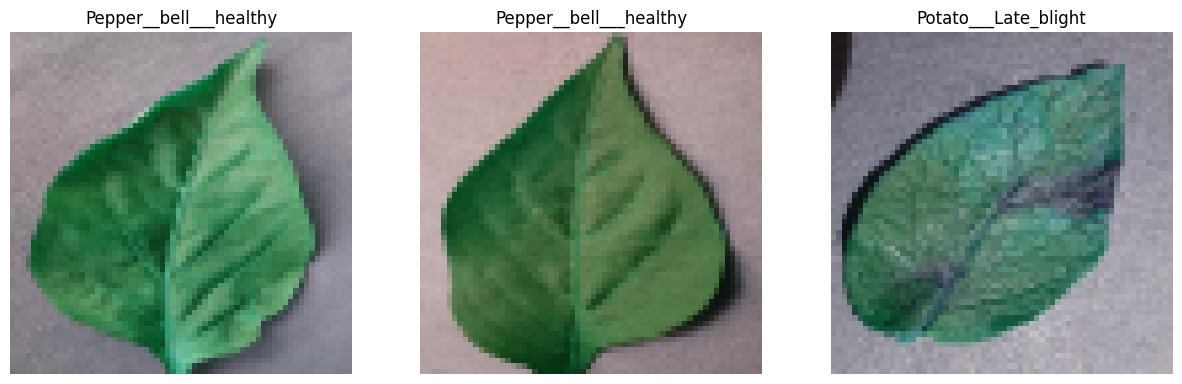

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

Model

In [17]:
EPOCHS = 10  # Reduced for faster execution; adjust as needed
BATCH_SIZE = 32  # Adjust based on your hardware capabilities
IMAGE_SIZE = 64  # Example image size, adjust as necessary
N_ch = 3  # Number of color channels (RGB)

In [18]:


#model building using dense net neural network

def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = densenet(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(15, activation='softmax')(x)  # Adjust the number of units based on the number of classes

    model = Model(inputs=input_layer, outputs=output)
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = build_densenet()

# Define callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.keras', verbose=1, save_best_only=True)

# Optional: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=360, width_shift_range=0.2, height_shift_range=0.2,
    zoom_range=0.2, horizontal_flip=True, vertical_flip=True
)

datagen.fit(X_train)



c:\Users\safag\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model Training


In [19]:

# Train the model
model.fit(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[annealer, checkpoint],
    validation_data=(X_val, Y_val)
)

Epoch 1/10


c:\Users\safag\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 2.77159, saving model to model.keras
115/115 - 100s - 866ms/step - accuracy: 0.2813 - loss: 2.8550 - val_accuracy: 0.2711 - val_loss: 2.7716 - learning_rate: 0.0020
Epoch 2/10


c:\Users\safag\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 2.77159
115/115 - 3s - 27ms/step - accuracy: 0.5938 - loss: 0.7481 - val_accuracy: 0.2862 - val_loss: 2.7900 - learning_rate: 0.0020
Epoch 3/10

Epoch 3: val_loss did not improve from 2.77159
115/115 - 48s - 419ms/step - accuracy: 0.7422 - loss: 0.9812 - val_accuracy: 0.3434 - val_loss: 3.8355 - learning_rate: 0.0020
Epoch 4/10

Epoch 4: val_loss did not improve from 2.77159
115/115 - 3s - 28ms/step - accuracy: 0.8438 - loss: 0.5044 - val_accuracy: 0.3380 - val_loss: 3.8565 - learning_rate: 0.0020
Epoch 5/10

Epoch 5: val_loss improved from 2.77159 to 1.89633, saving model to model.keras
115/115 - 51s - 447ms/step - accuracy: 0.8588 - loss: 0.4888 - val_accuracy: 0.6361 - val_loss: 1.8963 - learning_rate: 0.0020
Epoch 6/10

Epoch 6: val_loss improved from 1.89633 to 1.83999, saving model to model.keras
115/115 - 5s - 40ms/step - accuracy: 0.8125 - loss: 0.3529 - val_accuracy: 0.6501 - val_loss: 1.8400 - learning_rate: 0.0020
Epoch 7/10

Epoch 7: 

Model evaluation

In [20]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9436 - loss: 0.2300
Final Loss: 0.26141825318336487, Final Accuracy: 0.9330453276634216


saving the model

In [21]:


# Or, if you prefer to save as a single H5 file (less recommended for deployment)
model.save('final_model.keras')


Prediction

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step


Text(0.5, 192.58159722222217, 'Predicted')

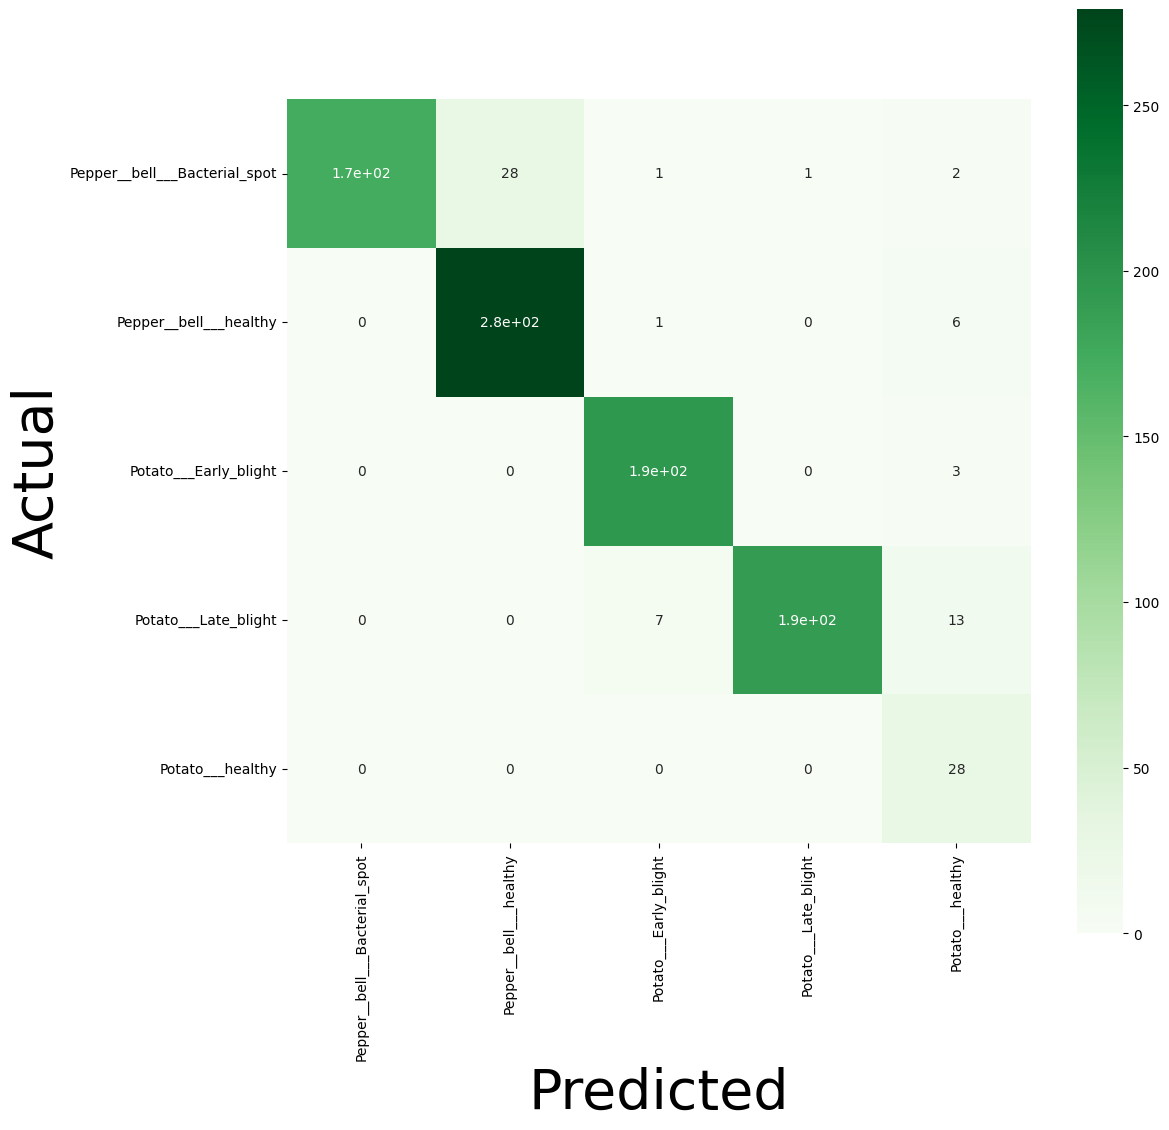

In [22]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

Testing Disease Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[0.03037442 0.0480703  0.66334426 0.02585729 0.05507758 0.01517671
 0.00351234 0.01371464 0.0177665  0.0246187  0.01987244 0.02391521
 0.00797137 0.0155767  0.0351515 ]


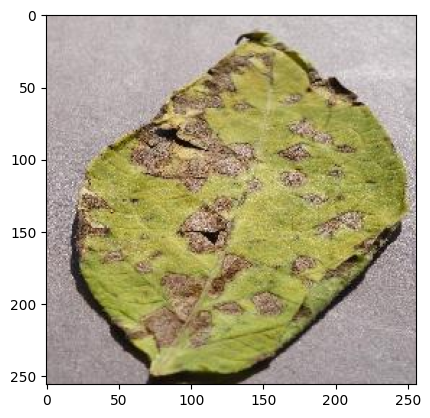

Prediction: Potato___Early_blight


In [27]:
from skimage import io
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the image using skimage
img = io.imread('PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG')

# Resize the image to the target size
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize the image

# Make a prediction using the model
custom = model.predict(img)
print(custom[0])

# Display the image
plt.imshow(io.imread('PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG'))
plt.show()

# Define the disease classes
disease_class = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Get the predicted class
predicted_class_index = np.argmax(custom[0])
predicted_class = disease_class[predicted_class_index]
print('Prediction:', predicted_class)
